In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import entropy as scipy_entropy

from sklearn.ensemble import RandomTreesEmbedding
from sklearn.tree import DecisionTreeClassifier
import sys
sys.path.append("../src/ppscore")
from preprocessing import RobustKBinsDiscretizer

# Code

In [764]:
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, clone
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from preprocessing import RobustKBinsDiscretizer

from copy import deepcopy

class MutualInformationForest(RandomForestClassifier):
    
    """A decision tree classifier where the target is discretized. usefull to transform regression into classification.
    One can choose to discretize X as well or not. Discretization is performed using RobustKBinsDiscretizer. 
    This estimator is robust to np.inf, -np.inf and np.nans if handle_nan is set to True. if one chooses to discretize X, it is also robust in the same cases.
    Also, this implementation exposesget_leaf_entropies and get_information_gain as usefull methods for mutual information estimation.
        
    
    """
    
    
    def __init__(        
        self,
        n_estimators=1,
        *,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features="sqrt",
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        ccp_alpha=0.0,
        max_samples=None,
        #quantization params
        n_bins_X=None,        
        n_bins_y=10,        
        strategy_X='kmeans',
        strategy_y='kmeans',
        handle_nan_X = 'handle', #error, handle, ignore        
        handle_nan_y = 'error', #error, handle, ignore        
    ):
        
        
        
        self.n_bins_X = n_bins_X
        self.n_bins_y = n_bins_y
        self.strategy_X = strategy_X
        self.strategy_y = strategy_y
        self.handle_nan_X = handle_nan_X
        self.handle_nan_y = handle_nan_y
        super().__init__(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples,
        )
        return
    
    def _ensure_2d(self, arr):
        if arr.ndim == 1:
            arr = arr.reshape(-1,1)
        return arr
    
    def _fit_preprocess_data(self, X, y = None):        
        
        X = np.array(X)
        
        X = self._ensure_2d(X)
        max_X = np.finfo(np.float32).max
        min_X = np.finfo(np.float32).min        

        if not self.n_bins_X is None:
            nanimputer = FunctionTransformer()
            infimputer = FunctionTransformer()
            neginfimputer = FunctionTransformer()
            x_quant = RobustKBinsDiscretizer(self.n_bins_X, encode = "ordinal", handle_nan = self.handle_nan_X, strategy=self.strategy_X, return_sparse = False)
        else:
            if self.handle_nan_X == "handle":
                nanimputer = FunctionTransformer(lambda x: np.where(x!=x,min_X, x))                     
                infimputer = FunctionTransformer(lambda x: np.where(x==np.inf,max_X, x))
                neginfimputer = FunctionTransformer(lambda x: np.where(x==-np.inf,min_X+1, x))             
                x_quant = FunctionTransformer()
            else:
                nanimputer = FunctionTransformer()
                infimputer = FunctionTransformer()
                neginfimputer = FunctionTransformer()
                x_quant = FunctionTransformer()
                
                
        
        if not y is None:
            y = np.array(y)
            y = self._ensure_2d(y)
            if not y.dtype in (float,int):
                caster = FunctionTransformer(lambda d: d.astype(str))
                enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
                self.y_preprocessor = make_pipeline(caster,enc).fit(y)
            
            else:

                max_y = np.finfo(np.float32).max
                min_y = np.finfo(np.float32).min        

                y_infimputer = FunctionTransformer(lambda x: np.where(x==np.inf,max_y, x))
                y_neginfimputer = FunctionTransformer(lambda x: np.where(x==-np.inf,min_y+1, x))     
                
                y_caster = FunctionTransformer(lambda d: d.astype(str))

                y_quant = RobustKBinsDiscretizer(self.n_bins_y, encode = "ordinal", handle_nan = self.handle_nan_y, strategy=self.strategy_y, return_sparse = False)
                self.y_preprocessor = make_pipeline(y_infimputer, y_neginfimputer, y_quant).fit(y)
        
        self.X_preprocessor = make_pipeline(infimputer, neginfimputer, nanimputer, x_quant).fit(X)
    
    def _preprocess_data(self, X, y = None):
        X = self._ensure_2d(X)
        X = self.X_preprocessor.transform(X)
        if not y is None:
            y = self._ensure_2d(y)
            y = self.y_preprocessor.transform(y)
        else:
            y = None
        
        return X, y
    
    def fit(self, X, y = None, sample_weight = None):
        self._fit_preprocess_data(X,y)
        X,y = self._preprocess_data(X,y)
        
        super().fit(X,y, sample_weight)
        return self
    
    def predict(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict(X, **kwargs)
    
    def apply(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().apply(X, **kwargs)
    
    def predict_proba(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict_proba(X, **kwargs)
    
    def predict_log_proba(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict_log_proba(X, **kwargs)
    
    def cost_complexity_pruning_path(self, X, y = None, **kawrgs):
        X,y = self._preprocess_data(X,y)
        return super().cost_complexity_pruning_path(X, y, **kwargs)

    def decision_path(self, X):
        X,y = self._preprocess_data(X,None)
        return super().decision_path(X)
    
    def leaf_entropies(self, X, y, sample_weight = None, shuffle = False, joint = False):
                
        y = np.array(y)        
        y = self._ensure_2d(y)                        
                
        X,y = self._preprocess_data(X,y)
                                            
        leafs = self.apply(X)
        if shuffle: 
            shuffled_idxs = np.random.choice(np.arange(len(leafs)), len(leafs), replace = False)
            leafs = leafs[shuffled_idxs]
                
        #flatten avoiding colisions
        n_trees = leafs.shape[1]
        leafs = leafs + (leafs.max(0)+1).cumsum()
        leafs = leafs.T.flatten().reshape(-1,1)
        y=np.vstack(n_trees*[y])
        if not sample_weight is None:
            sample_weight=np.hstack(n_trees*[sample_weight.flatten()])
                
        if sample_weight is None:
            total_sample_size = len(y)
            a = np.hstack([leafs,y])            
            a = a[a[:, 0].argsort()]            
            if not joint:
                
                entropies = np.array([[(len(i)/total_sample_size)*entropy(i) for i in np.split(a[:, j+1], np.unique(a[:, 0], return_index=True)[1][1:])] for j in range(y.shape[1])]).T
            else:                
                entropies = np.array([[(len(i)/total_sample_size)*entropy(i) for i in np.split(a[:, 1:], np.unique(a[:, 0], return_index=True)[1][1:])]]).T
            
        else:
            total_sample_size = np.sum(sample_weight)
            a = np.array([leafs,y, sample_weight]).T
            a = a[a[:, 0].argsort()]
            groups = np.split(a[:, 1:], np.unique(a[:, 0], return_index=True)[1][1:])
            entropies = np.array([(len(i)/total_sample_size)*entropy(i[:,0], i[:,1]) for i in groups])
                
        
        return entropies
    
    def conditional_mutual_information(self, X, y, sample_weight = None, normalize = True):
                        
        sample_entropy = self.leaf_entropies(X, y, sample_weight, shuffle = False, joint = False)                
        joint_sample_entropy = self.leaf_entropies(X, y, sample_weight, shuffle = False, joint = True)
        
        Hjoint = joint_sample_entropy.sum(0)
        Hmarginal =  sample_entropy.sum(0)
                
        cmi = Hmarginal.sum() - Hjoint
        if normalize:
            shuffled_sample_entropy = self.leaf_entropies(X, y, sample_weight, shuffle = True, joint = False)
            joint_shuffled_sample_entropy = self.leaf_entropies(X, y, sample_weight, shuffle = True, joint = True)
            norm = shuffled_sample_entropy.sum() - joint_shuffled_sample_entropy.sum()
            cmi = cmi/norm
            
        return max(0, cmi)
    
    def mutual_information(self, X, y, sample_weight = None, normalize = True):
        #H(x)
        joint_shuffled_sample_entropy = self.leaf_entropies(X, y, sample_weight, shuffle = True, joint = True)
        #H(x|y)
        joint_sample_entropy = self.leaf_entropies(X, y, sample_weight, shuffle = False, joint = True)
                                
        mi = joint_shuffled_sample_entropy.sum() - joint_sample_entropy.sum()
        if normalize:            
            norm = joint_shuffled_sample_entropy.sum()
            mi = mi/norm            
        return max(0, mi)
    
    
    def score(self, X, y, sample_weight = None):
        return self.get_information_gain(X, y, sample_weight, n_bins = n_bins,infer_fitted_y = infer_fitted_y)
        
def entropy(leaf_targets, sample_weight = None):
    
    #case for joint entropy
    if leaf_targets.ndim > 1:
        if leaf_targets.shape[1] > 1:
            leaf_targets = ["_".join(i) for i in leaf_targets.astype(str)]
    
    if sample_weight is None:
        _, p = np.unique(leaf_targets, return_counts=True)
        p = p/p.sum()
        
    else:        
        p = np.zeros((leaf_targets.size, int(leaf_targets.max() + 1)), dtype = float)
        p[np.arange(leaf_targets.size), leaf_targets.astype(int)] = 1
        p = p*(sample_weight.reshape(-1,1))
        p = p.sum(0)
        p = p[p>0]
        p = p/p.sum()        
    return np.sum(-p*np.log(p))        


In [585]:
d = np.random.randint(0,10,(10000,10)).astype(str)

In [676]:
entropy(np.random.randint(0,10,(10000,2)))

4.599760668326104

# Data

In [570]:
n = 10_000
# X = np.random.randn(n)
# Y = X**2 + np.random.randn(n)
# Z = X*Y + 10*np.random.binomial(1,0.3, n)

X = np.random.uniform(-3,3,n)
Y = np.random.lognormal(0,1.3,n)
cat= np.random.binomial(1,0.3, n )
W = np.random.uniform(-3,3,n)
Z = X*Y + Y*10*cat + 3*np.random.randn(n)# + 10*np.random.binomial(1,0.3, n)


In [401]:
XY = np.array([X,Y]).T
XZ = np.array([X,Z]).T
YZ = np.array([Y,Z]).T
XYZ = np.array([X,Y,Z]).T

XYZWcat = np.array([X,Y,Z,W,cat]).T

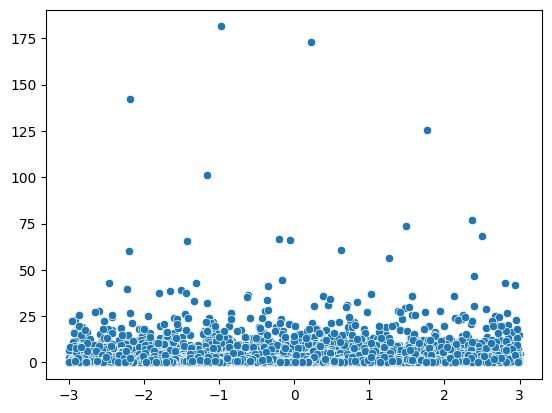

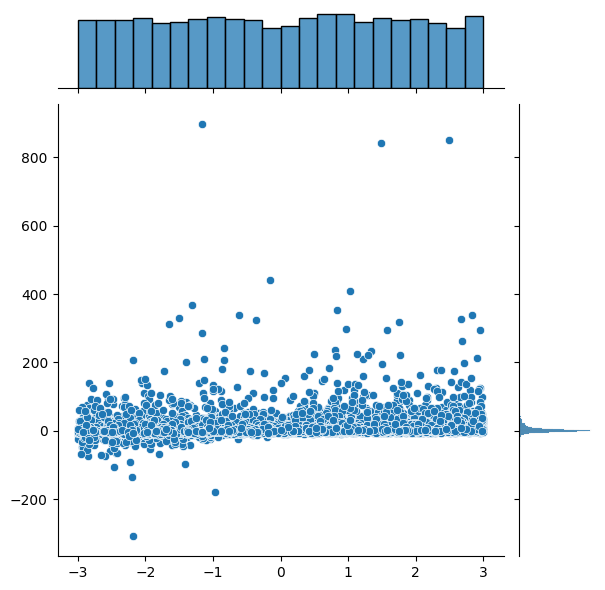

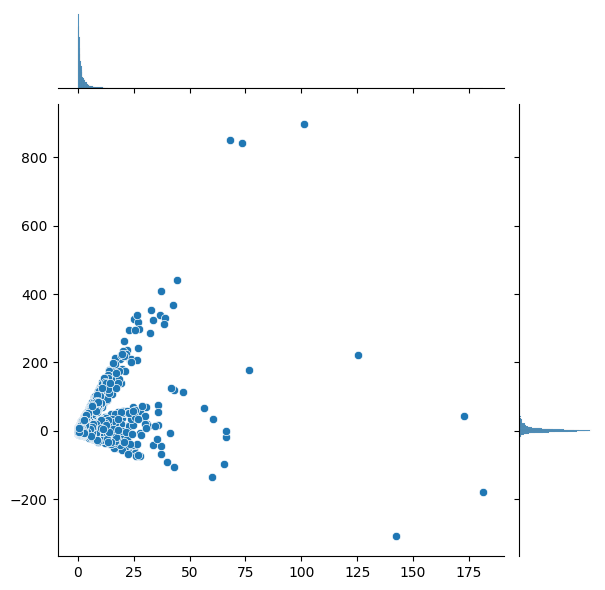

In [402]:
sns.scatterplot(x=X,y=Y)
sns.jointplot(x=X,y=Z)
sns.jointplot(x=Y,y=Z)


In [403]:
from scipy import stats

In [765]:
# n = 100_000
# X = np.random.randn(n)
# Y = np.random.randn(n)
# cat = np.random.binomial(1, 0.3, size = n)
# Z = X + Y#+ 10*np.random.binomial(1,0.3, n)

In [766]:
XY = np.array([X,Y]).T
XZ = np.array([X,Z]).T
YZ = np.array([Y,Z]).T
Ycat = np.array([Y,cat]).T
XYcat = np.array([X,Y,cat]).T
XYZ = np.array([X,Y,Z]).T

# Test

In [767]:
from sklearn.ensemble import RandomForestClassifier

In [768]:
cont_X = MutualInformationTree(max_leaf_nodes=200, n_bins_X=None, n_bins_y=10, strategy_y = "kmeans")
disc_X = MutualInformationTree(max_leaf_nodes=200, n_bins_X=30, n_bins_y=10, strategy_y = "kmeans",strategy_X = "kmeans")

forest = MutualInformationForest(1, max_leaf_nodes = 300,n_bins_X=None, n_bins_y=10, strategy_y = "kmeans")

In [769]:
train_size = 4_000

In [770]:
forest.fit(Z[:train_size],XY[:train_size]).mutual_information(Z[train_size:],XY[train_size:])

0.12280769410428705

In [776]:
forest.fit(X[:train_size],Y[:train_size]).mutual_information(X[train_size:],Y[train_size:])

0

In [787]:
forest.fit(X[:train_size],XY[:train_size]).mutual_information(X[train_size:],XY[train_size:])

0.6667876945638018

In [788]:
forest.fit(cat[:train_size],Z[:train_size]).mutual_information(cat[train_size:],Z[train_size:])

0.18072484326878363

In [577]:
%%timeit
forest.fit(Z[:train_size], XY[:train_size]).get_information_gain(Z[train_size:],XY[train_size:])

118 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [761]:
forest.fit(Z[:train_size], XYcat[:train_size]).conditional_mutual_information(Z[train_size:], XYcat[train_size:])

array([0.8256605])

In [562]:
%%timeit
cont_X.fit(XZ,Y).get_information_gain(XZ,Y)

UnboundLocalError: local variable 'n_bins' referenced before assignment

In [ ]:
%%timeit
forest.fit(XZ,Y).get_information_gain(XZ,Y)

In [ ]:
# TODO: Find structural dependency by finding uplift in pairs of predictors. then find the k cliques in the graph to determine the degree of dependency

In [217]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [218]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
from sklearn.model_selection import cross_val_predict

In [219]:
d = pd.DataFrame(XYZWcat)

In [220]:
f = lambda a,b,c: 0

In [222]:
cv = TimeSeriesSplit(4)
estimators = cross_validate(forest, XZ, Y, scoring = f, error_score = "raise", return_estimator = True, cv = cv)["estimator"]

In [223]:
estimators

[MutualInformationForest(max_leaf_nodes=300),
 MutualInformationForest(max_leaf_nodes=300),
 MutualInformationForest(max_leaf_nodes=300),
 MutualInformationForest(max_leaf_nodes=300)]

In [235]:
estimators = cross_validate(forest, XZ, Y, scoring = f, error_score = "raise", return_estimator = True, cv = cv)["estimator"]
d = [(XZ[i[1]],Y[i[1]]) for i in cv.split(XZ)]
Hxyz = [estimators[i].get_leaf_entropies(d[i][0], d[i][1], infer_fitted_y = True) for i in range(len(estimators))]
Hxz = [estimators[i].get_leaf_entropies(d[i][0], d[i][0][:,0], infer_fitted_y = False) for i in range(len(estimators))]
Hyz = [estimators[i].get_leaf_entropies(d[i][0], d[i][0][:,1], infer_fitted_y = False) for i in range(len(estimators))]

In [242]:
Hxyz[0]

IndexError: tuple index out of range

In [236]:
[np.mean(i) for i in Hxyz]
[np.mean(i) for i in Hyz]
[np.mean(i) for i in Hxz]

([0.0024813430234313493,
  0.0030108279045396947,
  0.004483750576302449,
  0.0038468063342648184],
 [0.002456506261905687,
  0.0029107887772720055,
  0.0018650955569435043,
  0.0022072126522987645],
 [0.004735188493761586,
  0.005712362524892707,
  0.005101251996585204,
  0.005236648966560195])

In [221]:
%%timeit
cross_validate(forest, XZ, Y, scoring = f, error_score = "raise", return_estimator = True)


KeyboardInterrupt

